In [1]:
#%pip install -r requirements.txt

import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
interest_rate = pd.read_csv('./data/interest_rate.csv')
energy_price = pd.read_csv('./data/energy_price.csv')
cpi = pd.read_csv('./data/cpi.csv')

In [3]:
interest_rate.head(1000)

,location,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term
0,AUS,7.177895,2000,1,5.66,5.00
1,AUS,6.957619,2000,2,5.80,5.48
2,AUS,6.570435,2000,3,5.89,5.50
3,AUS,6.264706,2000,4,6.04,5.72
4,AUS,6.465652,2000,5,6.31,5.98
...,...,...,...,...,...,...
995,USA,2.530000,2014,9,0.12,0.09
996,USA,2.300000,2014,10,0.12,0.09
997,USA,2.330000,2014,11,0.13,0.09
998,USA,2.210000,2014,12,0.15,0.12


In [4]:
cpi.head(1000)

,location,cpi-index,year,month
0,AUS,3.700000,1948,9
1,AUS,3.733333,1948,10
2,AUS,3.766667,1948,11
3,AUS,3.800000,1948,12
4,AUS,3.833333,1949,1
...,...,...,...,...
995,USA,174.100000,2000,11
996,USA,174.000000,2000,12
997,USA,175.100000,2001,1
998,USA,175.800000,2001,2


In [5]:
energy_price.head(1000)

,energy_price,year,month,location
0,30.430,2003,1,AUS
1,31.845,2003,2,AUS
2,29.800,2003,3,AUS
3,25.380,2003,4,AUS
4,26.170,2003,5,AUS
...,...,...,...,...
627,109.550,2022,5,USA
628,114.840,2022,6,USA
629,101.620,2022,7,USA
630,93.670,2022,8,USA


In [6]:
df = interest_rate.merge(cpi, on=['location', 'year', 'month'], suffixes=('', '_delme'))
df = df.merge(energy_price, on=['location', 'year', 'month'], suffixes=('', '_delme'))
df = df[[c for c in df.columns if not c.endswith('_delme')]]

In [7]:
df.head(1000)

,location,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price
0,AUS,5.275000,2003,1,4.80,4.75,77.933333,30.430
1,AUS,5.167750,2003,2,4.75,4.75,78.266667,31.845
2,AUS,5.271667,2003,3,4.76,4.75,78.600000,29.800
3,AUS,5.346053,2003,4,4.79,4.75,78.600000,25.380
4,AUS,5.028182,2003,5,4.78,4.75,78.600000,26.170
...,...,...,...,...,...,...,...,...
504,USA,2.900000,2022,5,1.33,0.77,292.296000,109.550
505,USA,3.140000,2022,6,1.87,1.21,296.311000,114.840
506,USA,2.900000,2022,7,2.50,1.68,296.276000,101.620
507,USA,2.900000,2022,8,2.76,2.33,296.171000,93.670


In [8]:
#Columns present in the dataset
df.columns

Index(['location', 'interest_rate_long_term', 'year', 'month',
       'interest_rate_short_term', 'interest_rate_immediate_term', 'cpi-index',
       'energy_price'],
      dtype='object')

In [9]:
#Checking for null values
df.isnull().sum()

location                        0
interest_rate_long_term         0
year                            0
month                           0
interest_rate_short_term        0
interest_rate_immediate_term    0
cpi-index                       0
energy_price                    0
dtype: int64

In [10]:
#Checking datatypes of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509 entries, 0 to 508
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   location                      509 non-null    object 
 1   interest_rate_long_term       509 non-null    float64
 2   year                          509 non-null    int64  
 3   month                         509 non-null    int64  
 4   interest_rate_short_term      509 non-null    float64
 5   interest_rate_immediate_term  509 non-null    float64
 6   cpi-index                     509 non-null    float64
 7   energy_price                  509 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 35.8+ KB


In [11]:
#Stats of data
df.describe()

,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price
count,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000
mean,3.516274,2011.559921,6.451866,2.584715,2.393929,165.591124,65.468792
std,1.519468,6.226914,3.441316,2.146992,2.119507,65.185030,26.657197
min,0.620000,2000.000000,1.000000,0.010000,0.050000,77.933333,17.730000
25%,2.320000,2006.000000,3.000000,0.540000,0.250000,103.600000,44.940000
50%,3.397500,2012.000000,6.000000,2.070000,1.750000,177.100000,62.230000
75%,4.930000,2017.000000,9.000000,4.620000,4.480000,226.889000,86.330000
max,6.660000,2022.000000,12.000000,7.900000,7.250000,296.808000,133.930000


In [12]:
df.head(1000)

,location,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price
0,AUS,5.275000,2003,1,4.80,4.75,77.933333,30.430
1,AUS,5.167750,2003,2,4.75,4.75,78.266667,31.845
2,AUS,5.271667,2003,3,4.76,4.75,78.600000,29.800
3,AUS,5.346053,2003,4,4.79,4.75,78.600000,25.380
4,AUS,5.028182,2003,5,4.78,4.75,78.600000,26.170
...,...,...,...,...,...,...,...,...
504,USA,2.900000,2022,5,1.33,0.77,292.296000,109.550
505,USA,3.140000,2022,6,1.87,1.21,296.311000,114.840
506,USA,2.900000,2022,7,2.50,1.68,296.276000,101.620
507,USA,2.900000,2022,8,2.76,2.33,296.171000,93.670


,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price
interest_rate_long_term,1.000000,-0.893112,-0.022008,0.933878,0.924867,-0.868156,0.104256
year,-0.893112,1.000000,-0.027977,-0.893625,-0.909098,0.994436,0.175815
month,-0.022008,-0.027977,1.000000,-0.002032,-0.001685,0.024378,0.008825
interest_rate_short_term,0.933878,-0.893625,-0.002032,1.000000,0.995669,-0.875703,0.088292
interest_rate_immediate_term,0.924867,-0.909098,-0.001685,0.995669,1.000000,-0.893151,0.073959
cpi-index,-0.868156,0.994436,0.024378,-0.875703,-0.893151,1.000000,0.234833
energy_price,0.104256,0.175815,0.008825,0.088292,0.073959,0.234833,1.000000


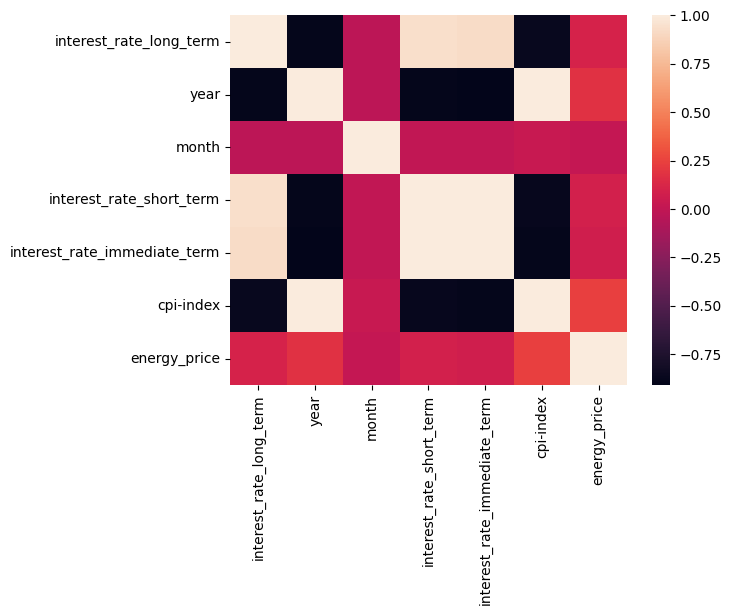

In [13]:
method='pearson'

df_au = df[df['location'] == 'AUS']

sns.heatmap(df_au.corr(numeric_only=True,method=method))
df_au.corr(numeric_only=True,method=method)

,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price
interest_rate_long_term,1.000000,-0.863408,-0.053153,0.767289,0.769266,-0.827503,-0.302359
year,-0.863408,1.000000,-0.020812,-0.544418,-0.555717,0.986641,0.368775
month,-0.053153,-0.020812,1.000000,-0.001169,-0.017956,0.019271,0.003808
interest_rate_short_term,0.767289,-0.544418,-0.001169,1.000000,0.984704,-0.511400,-0.250018
interest_rate_immediate_term,0.769266,-0.555717,-0.017956,0.984704,1.000000,-0.531066,-0.287792
cpi-index,-0.827503,0.986641,0.019271,-0.511400,-0.531066,1.000000,0.456888
energy_price,-0.302359,0.368775,0.003808,-0.250018,-0.287792,0.456888,1.000000


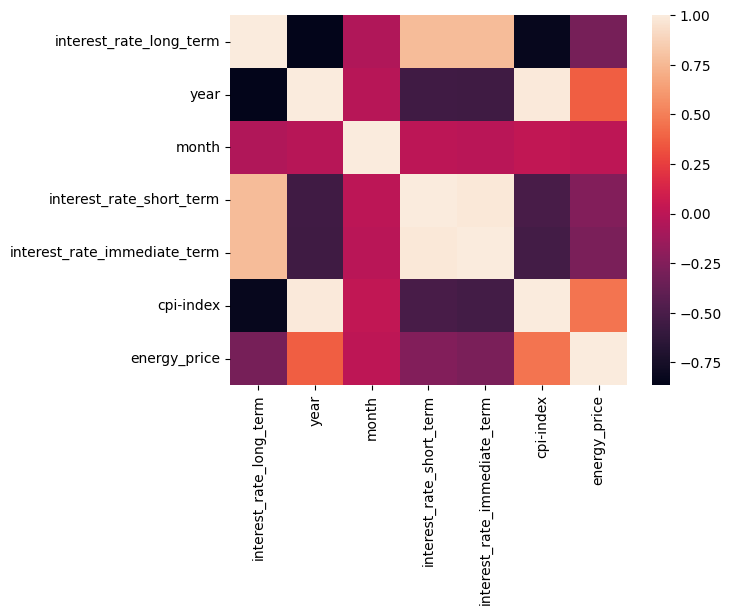

In [14]:
df_us = df[df['location'] == 'USA']

sns.heatmap(df_us.corr(numeric_only=True,method=method))
df_us.corr(numeric_only=True,method=method)

array([<AxesSubplot: xlabel='year,month'>,
       <AxesSubplot: xlabel='year,month'>], dtype=object)

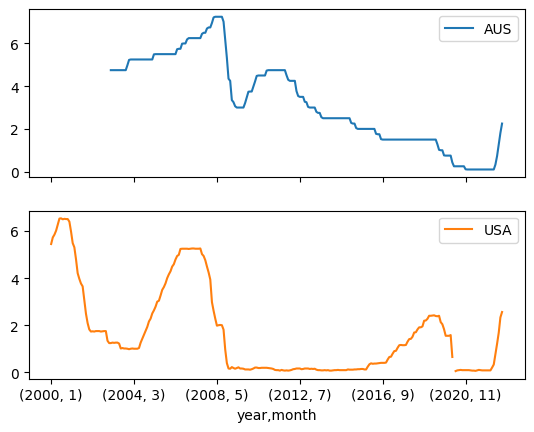

In [21]:
pd.pivot_table(df.reset_index(),
               index=['year','month'], columns='location', values='interest_rate_immediate_term'
              ).plot(subplots=True)

array([<AxesSubplot: xlabel='year,month'>,
       <AxesSubplot: xlabel='year,month'>], dtype=object)

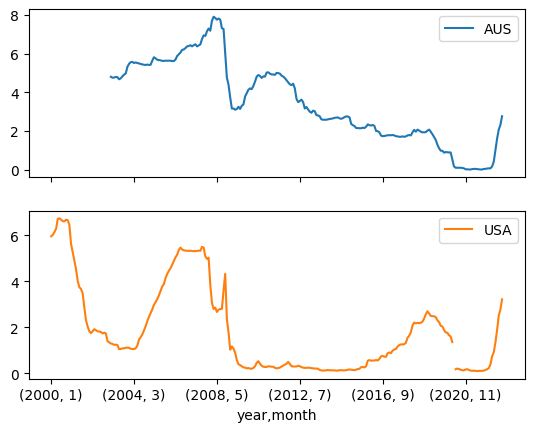

In [22]:
pd.pivot_table(df.reset_index(),
               index=['year','month'], columns='location', values='interest_rate_short_term'
              ).plot(subplots=True)

array([<AxesSubplot: xlabel='year,month'>,
       <AxesSubplot: xlabel='year,month'>], dtype=object)

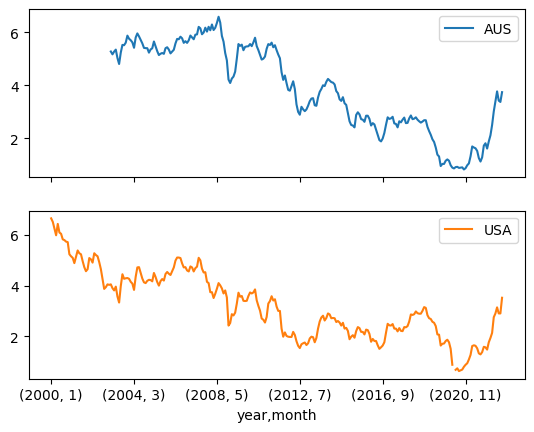

In [23]:
pd.pivot_table(df.reset_index(),
               index=['year','month'], columns='location', values='interest_rate_long_term'
              ).plot(subplots=True)

array([<AxesSubplot: xlabel='year,month'>,
       <AxesSubplot: xlabel='year,month'>], dtype=object)

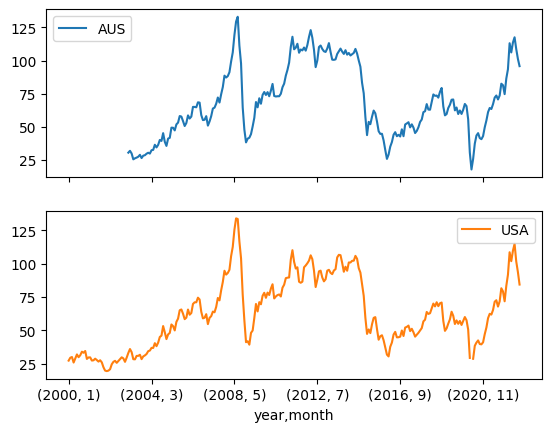

In [24]:
pd.pivot_table(df.reset_index(),
               index=['year','month'], columns='location', values='energy_price'
              ).plot(subplots=True)

array([<AxesSubplot: xlabel='year,month'>,
       <AxesSubplot: xlabel='year,month'>], dtype=object)

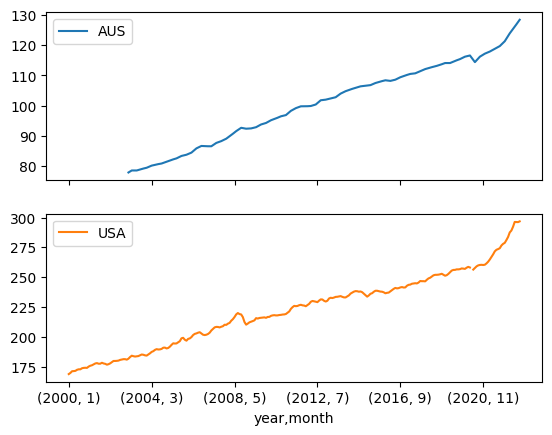

In [25]:
pd.pivot_table(df.reset_index(),
               index=['year','month'], columns='location', values='cpi-index'
              ).plot(subplots=True)

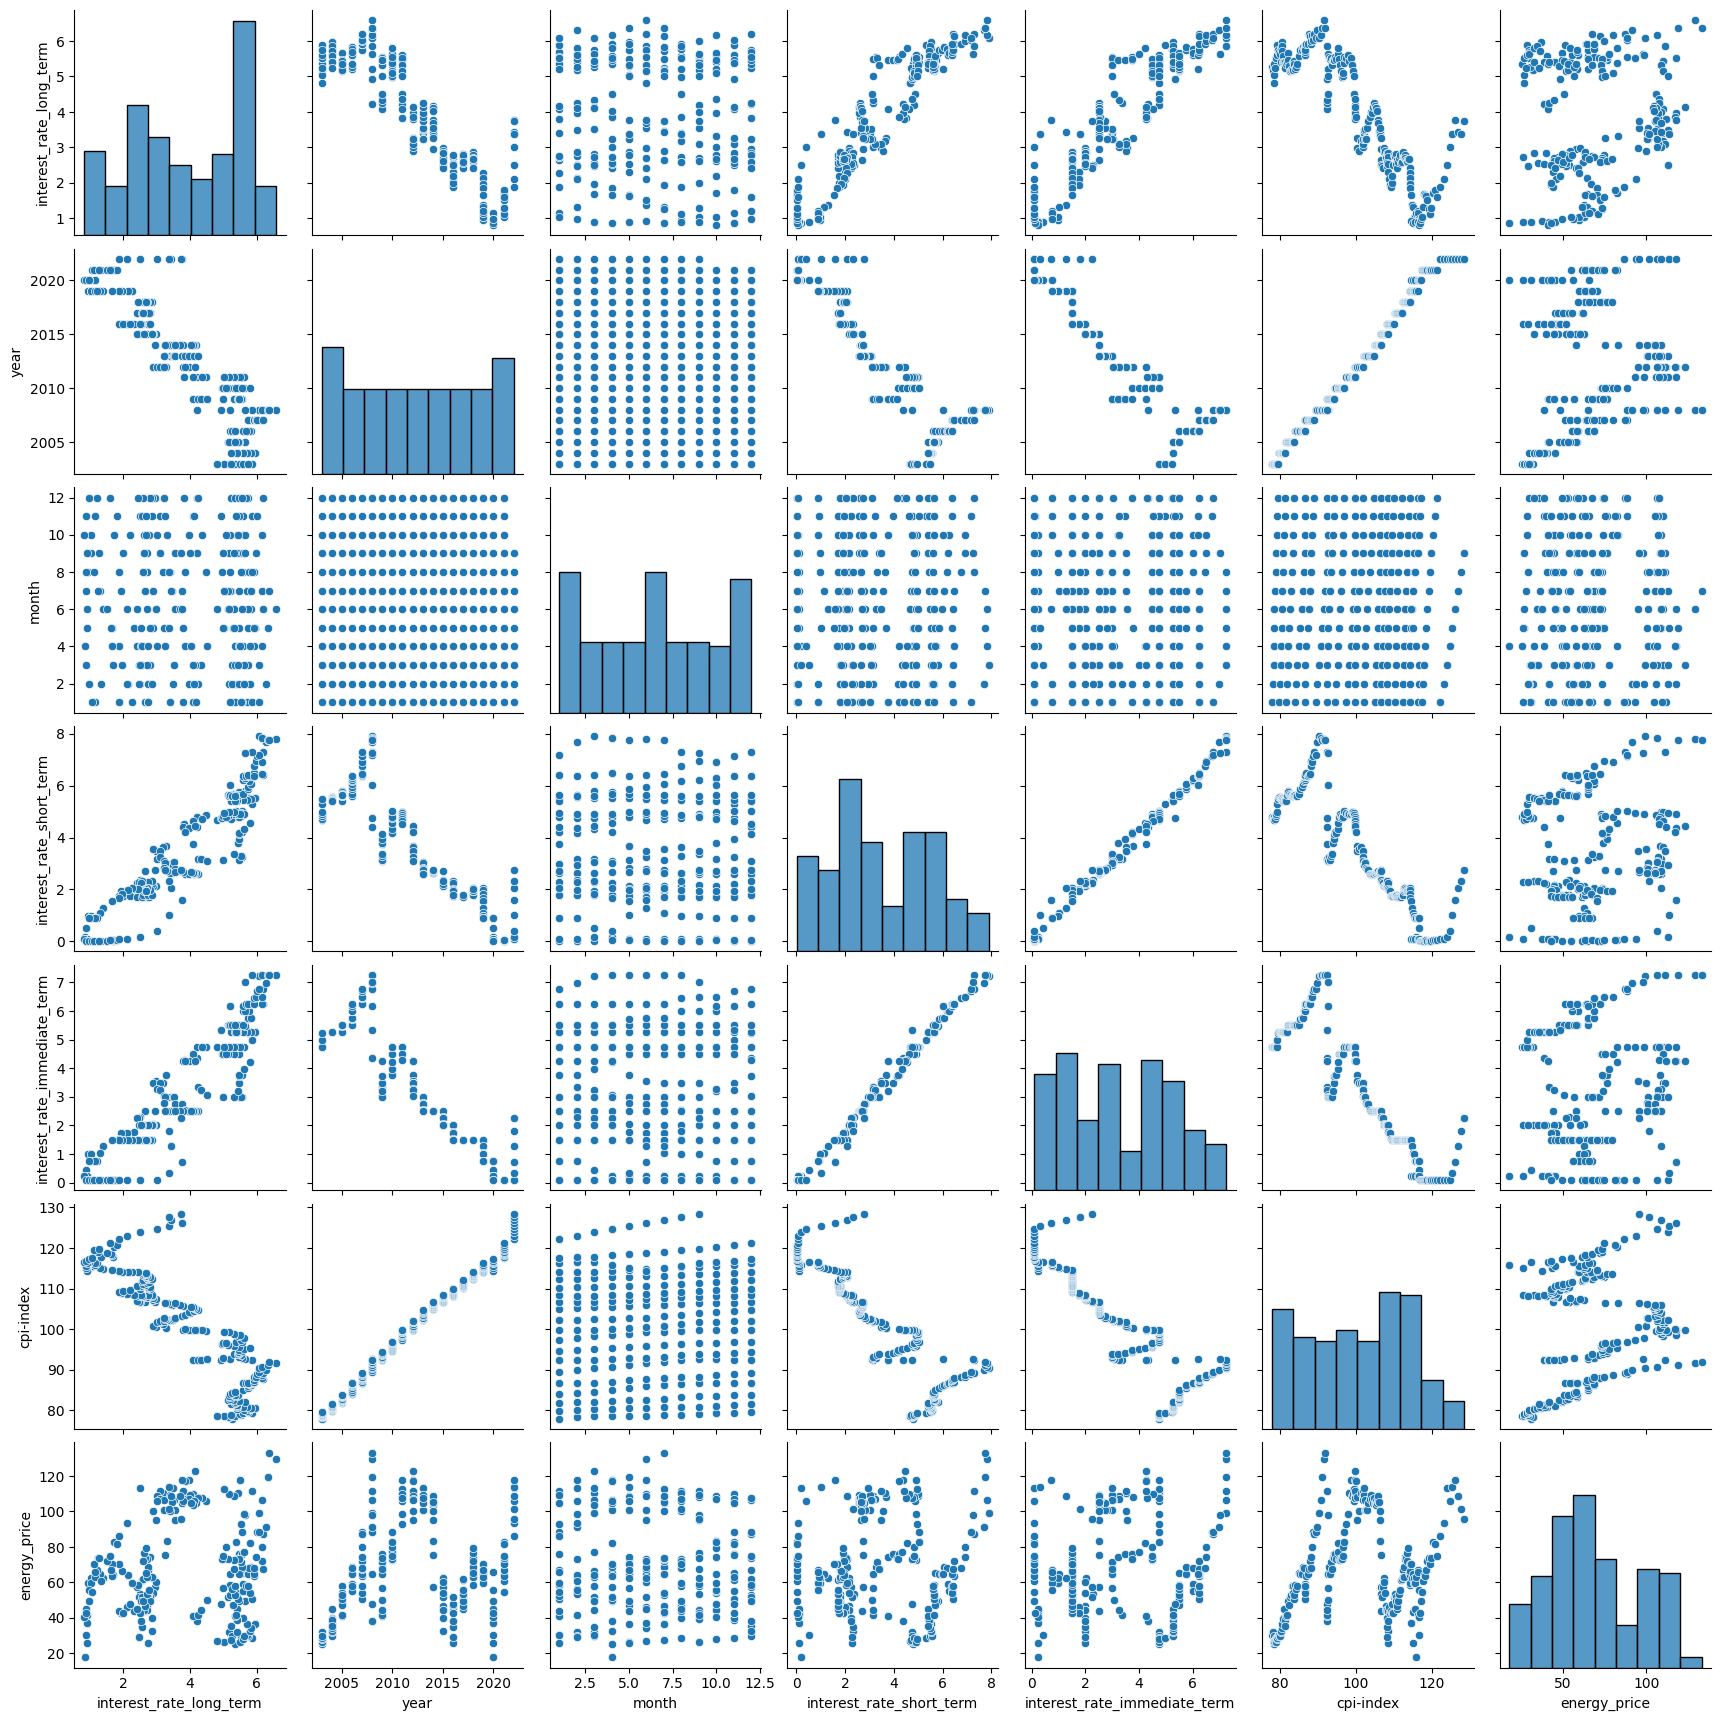

In [27]:
sns.pairplot(df_au)

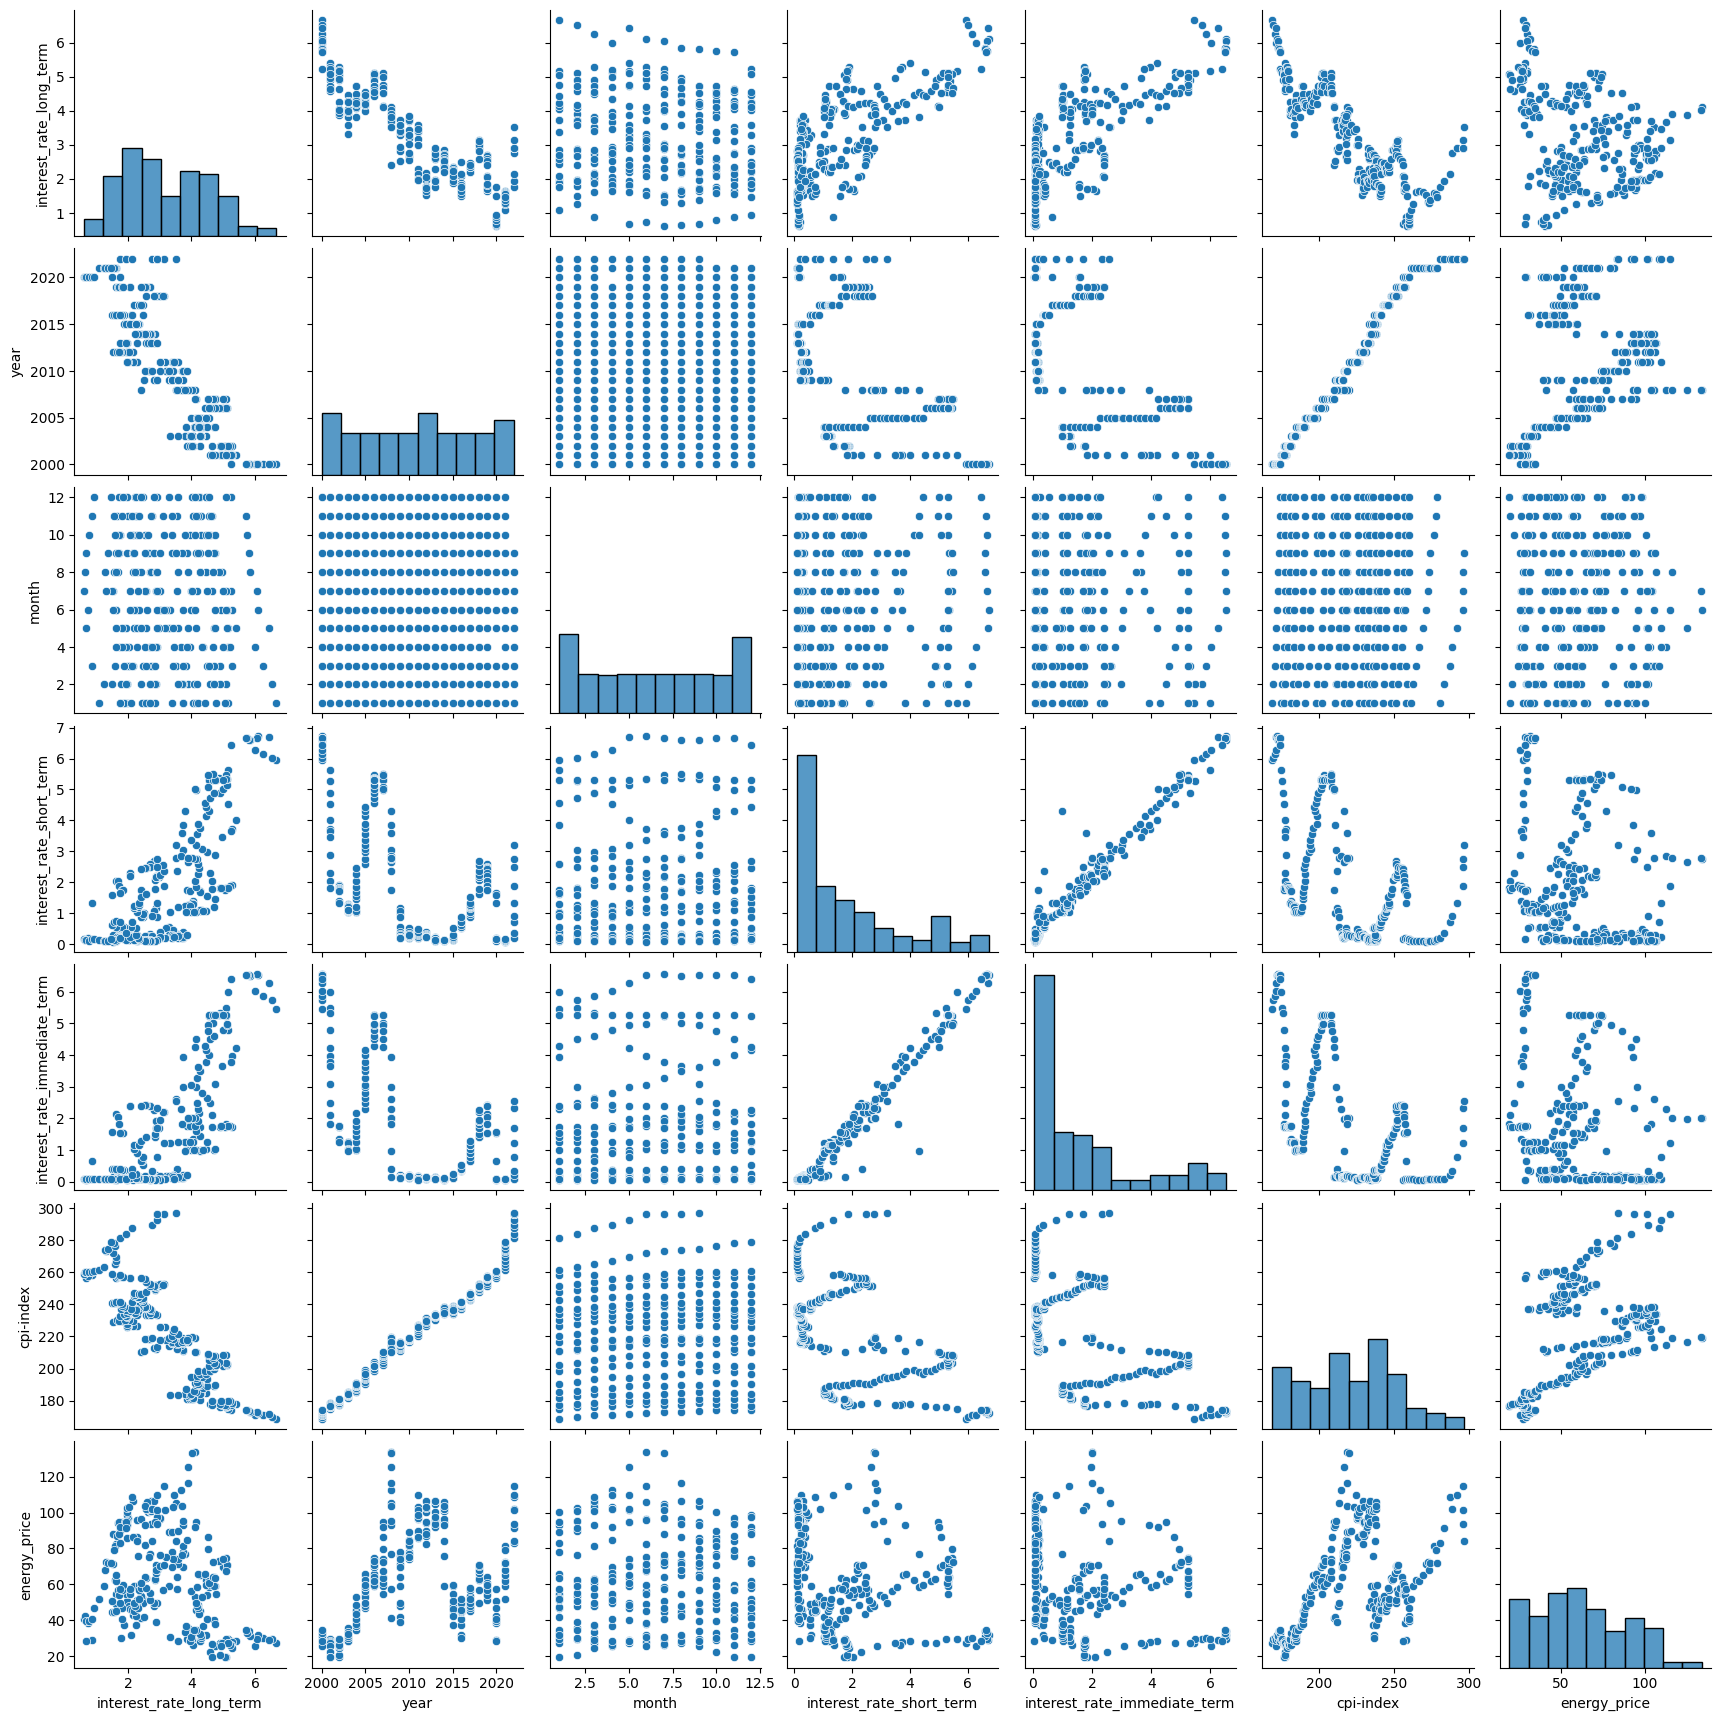

In [28]:
sns.pairplot(df_us)